# Brain age regression with fastai

Join here: http://tiny.cc/k8sihz

( Model adapted from https://analyticsindiamag.com/a-hands-on-guide-to-regression-with-fast-ai )

In [1035]:
# Import all libraries needed for the exploration

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd # this is how we usually import pandas
import numpy as np # this is how we usually import numpy
import pandas_profiling
import sys # only needed to determine Python version number
import matplotlib #only needed to determine Matplotlib version number
from fastai.tabular import *

# Enable inline plotting
%matplotlib inline

In [1036]:
# Supress some warnings:
import warnings
warnings.filterwarnings('ignore')

In [1037]:
print('Python version ' + sys.version)
print('Pandas version ' + pd.__version__)
print('Numpy version ' + np.__version__)
print('Matplotlib version ' + matplotlib.__version__)
print('Seaborn version ' + sns.__version__)

Python version 3.7.4 (default, Aug 13 2019, 20:35:49) 
[GCC 7.3.0]
Pandas version 0.25.3
Numpy version 1.17.4
Matplotlib version 3.1.2
Seaborn version 0.9.0


## Code

In [1038]:
!ls .

brain_age_classification.ipynb	   models
brain_age_explore_in_r.ipynb	   numpy-basics.ipynb
brain_age_explore.ipynb		   pandas-basics.ipynb
brain_age_regression_fastai.ipynb  python-basics.ipynb
brain_age_regression.ipynb	   scikit-learn-basics.ipynb
fastai_solution_1.csv		   submission.csv
fastai_solution_3.csv		   tabular_data_sol_3.csv
Fast_ai_solution.csv		   tabular_data_sol_4.csv
kernel_density_estimation.ipynb


## Data

In [1039]:
!ls ../data

foo.csv   FreesurferLUT.pkl	SLIM_longitudinal_info.csv
foo.h5	  iris.data		test.csv
foo.xlsx  sampleSubmission.csv	train.csv


## Training data

In [1040]:
train_data = pd.read_csv('../data/train.csv')

## Test data

In [1041]:
test_data = pd.read_csv('../data/test.csv')

### Explore the data

In [1042]:
# Check the number of data points in the data set
print('No observations:', len(train_data))
# Check the number of features in the data set
print('No variables:', len(train_data.columns))
# Check the data types
print(train_data.dtypes.unique())

No observations: 1085
No variables: 150
[dtype('int64') dtype('O') dtype('float64')]


In [1043]:
train_data.shape

(1085, 150)

In [1044]:
train_data.columns

Index(['SubjectID', 'Source', 'ID', 'Sex', 'Height', 'Weight', 'FieldStrength',
       'Handedness', 'Measure:volume', 'Left-Lateral-Ventricle',
       ...
       'rh_superiortemporal_thickness', 'rh_supramarginal_thickness',
       'rh_frontalpole_thickness', 'rh_temporalpole_thickness',
       'rh_transversetemporal_thickness', 'rh_insula_thickness',
       'rh_MeanThickness_thickness', 'BrainSegVolNotVent', 'eTIV_y', 'Age'],
      dtype='object', length=150)

In [1045]:
for i, col in enumerate(train_data.columns, start=0):
    print(i, col)

0 SubjectID
1 Source
2 ID
3 Sex
4 Height
5 Weight
6 FieldStrength
7 Handedness
8 Measure:volume
9 Left-Lateral-Ventricle
10 Left-Inf-Lat-Vent
11 Left-Cerebellum-White-Matter
12 Left-Cerebellum-Cortex
13 Left-Thalamus-Proper
14 Left-Caudate
15 Left-Putamen
16 Left-Pallidum
17 3rd-Ventricle
18 4th-Ventricle
19 Brain-Stem
20 Left-Hippocampus
21 Left-Amygdala
22 CSF
23 Left-Accumbens-area
24 Left-VentralDC
25 Left-vessel
26 Left-choroid-plexus
27 Right-Lateral-Ventricle
28 Right-Inf-Lat-Vent
29 Right-Cerebellum-White-Matter
30 Right-Cerebellum-Cortex
31 Right-Thalamus-Proper
32 Right-Caudate
33 Right-Putamen
34 Right-Pallidum
35 Right-Hippocampus
36 Right-Amygdala
37 Right-Accumbens-area
38 Right-VentralDC
39 Right-vessel
40 Right-choroid-plexus
41 5th-Ventricle
42 WM-hypointensities
43 Left-WM-hypointensities
44 Right-WM-hypointensities
45 non-WM-hypointensities
46 Left-non-WM-hypointensities
47 Right-non-WM-hypointensities
48 Optic-Chiasm
49 CC_Posterior
50 CC_Mid_Posterior
51 CC_Central

In [1046]:
# We may have some categorical features, let's check them
train_data.select_dtypes(include=['O']).columns.tolist()

['Source', 'ID', 'Sex', 'FieldStrength']

In [1047]:
# Check any number of columns with NaN
print(train_data.isnull().any().sum(), ' / ', len(train_data.columns))
# Check number of data points with any NaN
print(train_data.isnull().any(axis=1).sum(), ' / ', len(train_data))

4  /  150
1085  /  1085


### Select features and targets

In [1048]:
features = train_data.iloc[:,9:-1].columns.tolist()
target = train_data.iloc[:,-1].name

In [1049]:
all_lh_features = [
 'CSF', 'CC_Posterior', 'CC_Mid_Posterior', 'CC_Central', 'CC_Mid_Anterior', 'CC_Anterior', 'EstimatedTotalIntraCranialVol',
 'Left-Lateral-Ventricle',
 'Left-Inf-Lat-Vent',
 'Left-Cerebellum-White-Matter',
 'Left-Cerebellum-Cortex',
 'Left-Thalamus-Proper',
 'Left-Caudate',
 'Left-Putamen',
 'Left-Pallidum',
 'Left-Hippocampus',
 'Left-Amygdala',
 'Left-Accumbens-area',
 'Left-VentralDC',
 'Left-vessel',
 'Left-choroid-plexus',
 'Left-WM-hypointensities',
 'Left-non-WM-hypointensities',
 'lhCortexVol',
 'lhCerebralWhiteMatterVol',            
 'lhSurfaceHoles',  
 'lh_bankssts_thickness',
 'lh_caudalanteriorcingulate_thickness',
 'lh_caudalmiddlefrontal_thickness',
 'lh_cuneus_thickness',
 'lh_entorhinal_thickness',
 'lh_fusiform_thickness',
 'lh_inferiorparietal_thickness',
 'lh_inferiortemporal_thickness',
 'lh_isthmuscingulate_thickness',
 'lh_lateraloccipital_thickness',
 'lh_lateralorbitofrontal_thickness',
 'lh_lingual_thickness',
 'lh_medialorbitofrontal_thickness',
 'lh_middletemporal_thickness',
 'lh_parahippocampal_thickness',
 'lh_paracentral_thickness',
 'lh_parsopercularis_thickness',
 'lh_parsorbitalis_thickness',
 'lh_parstriangularis_thickness',
 'lh_pericalcarine_thickness',
 'lh_postcentral_thickness',
 'lh_posteriorcingulate_thickness',
 'lh_precentral_thickness',
 'lh_precuneus_thickness',
 'lh_rostralanteriorcingulate_thickness',
 'lh_rostralmiddlefrontal_thickness',
 'lh_superiorfrontal_thickness',
 'lh_superiorparietal_thickness',
 'lh_superiortemporal_thickness',
 'lh_supramarginal_thickness',
 'lh_frontalpole_thickness',
 'lh_temporalpole_thickness',
 'lh_transversetemporal_thickness',
 'lh_insula_thickness',
 'lh_MeanThickness_thickness'
 ]

In [1050]:
# Make rh_ and Right- names (base on LHs)

# List comprehensions
rh_names = [w.replace('lh_', 'rh_') for w in all_lh_features]
Right_names = [w.replace('Left-', 'Right-') for w in rh_names]
most_rh_names = [w.replace('lhC', 'rhC') for w in Right_names]
all_rh_features = [w.replace('lhS', 'rhS') for w in most_rh_names]
all_rh_features

['CSF',
 'CC_Posterior',
 'CC_Mid_Posterior',
 'CC_Central',
 'CC_Mid_Anterior',
 'CC_Anterior',
 'EstimatedTotalIntraCranialVol',
 'Right-Lateral-Ventricle',
 'Right-Inf-Lat-Vent',
 'Right-Cerebellum-White-Matter',
 'Right-Cerebellum-Cortex',
 'Right-Thalamus-Proper',
 'Right-Caudate',
 'Right-Putamen',
 'Right-Pallidum',
 'Right-Hippocampus',
 'Right-Amygdala',
 'Right-Accumbens-area',
 'Right-VentralDC',
 'Right-vessel',
 'Right-choroid-plexus',
 'Right-WM-hypointensities',
 'Right-non-WM-hypointensities',
 'rhCortexVol',
 'rhCerebralWhiteMatterVol',
 'rhSurfaceHoles',
 'rh_bankssts_thickness',
 'rh_caudalanteriorcingulate_thickness',
 'rh_caudalmiddlefrontal_thickness',
 'rh_cuneus_thickness',
 'rh_entorhinal_thickness',
 'rh_fusiform_thickness',
 'rh_inferiorparietal_thickness',
 'rh_inferiortemporal_thickness',
 'rh_isthmuscingulate_thickness',
 'rh_lateraloccipital_thickness',
 'rh_lateralorbitofrontal_thickness',
 'rh_lingual_thickness',
 'rh_medialorbitofrontal_thickness',
 'r

In [1051]:
#train_data_lh = train_data[all_lh_features]
# train_data_rh = train_dat[item for item in temp1 if item not in temp2]a[all_rh_features]

In [1052]:
train_data_lh.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
CSF,1085.0,1032.72,275.51,550.90,849.50,989.90,1154.00,3135.60
CC_Posterior,1085.0,998.76,165.01,259.40,890.20,996.00,1085.90,1824.10
CC_Mid_Posterior,1085.0,564.41,133.13,115.50,479.50,548.60,632.40,1447.20
CC_Central,1085.0,660.53,182.18,255.70,511.10,656.20,794.80,1289.50
CC_Mid_Anterior,1085.0,646.39,178.89,247.40,504.60,634.80,769.00,1294.70
...,...,...,...,...,...,...,...,...
lh_frontalpole_thickness,1085.0,2.84,0.29,1.58,2.64,2.85,3.02,3.68
lh_temporalpole_thickness,1085.0,3.68,0.29,2.29,3.51,3.70,3.88,4.46
lh_transversetemporal_thickness,1085.0,2.30,0.23,1.26,2.16,2.31,2.46,3.04
lh_insula_thickness,1085.0,2.97,0.19,1.50,2.87,2.98,3.10,3.55


In [1053]:
train_data_rh.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
CSF,1085.0,1032.72,275.51,550.90,849.50,989.90,1154.00,3135.60
CC_Posterior,1085.0,998.76,165.01,259.40,890.20,996.00,1085.90,1824.10
CC_Mid_Posterior,1085.0,564.41,133.13,115.50,479.50,548.60,632.40,1447.20
CC_Central,1085.0,660.53,182.18,255.70,511.10,656.20,794.80,1289.50
CC_Mid_Anterior,1085.0,646.39,178.89,247.40,504.60,634.80,769.00,1294.70
...,...,...,...,...,...,...,...,...
rh_frontalpole_thickness,1085.0,2.81,0.28,1.98,2.63,2.80,3.01,3.74
rh_temporalpole_thickness,1085.0,3.76,0.30,2.23,3.57,3.78,3.96,4.57
rh_transversetemporal_thickness,1085.0,2.35,0.24,1.31,2.22,2.37,2.52,3.05
rh_insula_thickness,1085.0,2.99,0.20,1.49,2.87,3.00,3.12,3.59


In [1054]:
dropcolumns = [
    'EstimatedTotalIntraCranialVol',
    'CSF', 
    'CC_Posterior', 
    'CC_Mid_Posterior', 
    'CC_Central', 
    'CC_Mid_Anterior', 
    'CC_Anterior'   
]

df_lh = train_data_lh.drop(dropcolumns, axis=1)
df_rh = train_data_rh.drop(dropcolumns, axis=1)
df_lh

,Left-Lateral-Ventricle,Left-Inf-Lat-Vent,Left-Cerebellum-White-Matter,Left-Cerebellum-Cortex,Left-Thalamus-Proper,Left-Caudate,Left-Putamen,Left-Pallidum,Left-Hippocampus,Left-Amygdala,...,lh_rostralmiddlefrontal_thickness,lh_superiorfrontal_thickness,lh_superiorparietal_thickness,lh_superiortemporal_thickness,lh_supramarginal_thickness,lh_frontalpole_thickness,lh_temporalpole_thickness,lh_transversetemporal_thickness,lh_insula_thickness,lh_MeanThickness_thickness
0,5968.4,212.0,12717.4,54979.7,8170.7,3773.4,5204.9,1956.4,4150.9,1515.2,...,2.560,2.924,2.379,2.953,2.642,3.043,3.662,2.460,3.062,2.63478
1,12256.1,241.9,15603.7,50793.1,8513.6,4153.9,5317.9,2330.4,3971.8,1692.1,...,2.530,2.981,2.333,2.817,2.715,2.763,3.699,2.395,3.242,2.60656
2,4764.0,202.1,13745.1,44080.0,7312.0,3320.8,4137.5,1797.2,3465.7,1377.4,...,2.551,2.882,2.286,2.790,2.710,2.676,4.050,2.225,2.902,2.57094
3,10770.0,532.2,13814.3,50342.0,7367.5,2726.2,4771.3,2122.2,4046.3,1476.0,...,2.418,2.516,2.180,2.780,2.662,2.880,3.712,2.179,2.566,2.45492
4,6773.7,517.0,15662.8,54779.1,7156.6,3357.3,4940.3,2010.9,4109.7,1435.1,...,2.302,2.505,2.062,2.579,2.453,2.736,3.646,1.956,2.889,2.36957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1080,3794.7,31.7,19280.4,58613.7,8924.1,3090.4,5180.6,2285.0,4595.9,1527.1,...,2.408,2.603,2.162,2.468,2.301,2.857,3.066,1.928,2.742,2.38182
1081,17935.0,473.7,16101.9,48996.3,6542.0,3430.0,3995.2,2043.6,3513.4,1403.0,...,2.164,2.458,2.039,2.501,2.425,2.373,3.441,2.077,2.423,2.28107
1082,3116.1,98.7,14541.8,58064.3,6351.6,2885.1,3963.1,1695.5,3680.0,1393.1,...,2.324,2.646,2.066,2.761,2.494,2.788,3.511,2.294,2.928,2.45424
1083,9992.8,412.2,15710.0,54893.8,6730.6,3002.5,3941.9,1888.4,3547.3,1340.1,...,2.154,2.401,1.956,2.563,2.238,2.741,3.286,1.779,2.458,2.20697


### Path / default location for saving/loading models

In [1055]:
path = ''

### The dependent variable/target

In [1056]:
dep_var = 'Age'

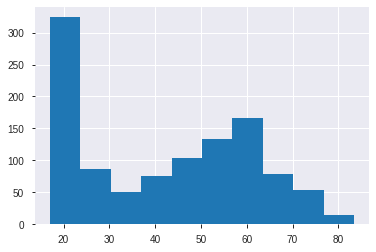

In [1057]:
y = train_data[dep_var]
y.hist()
plt.show()

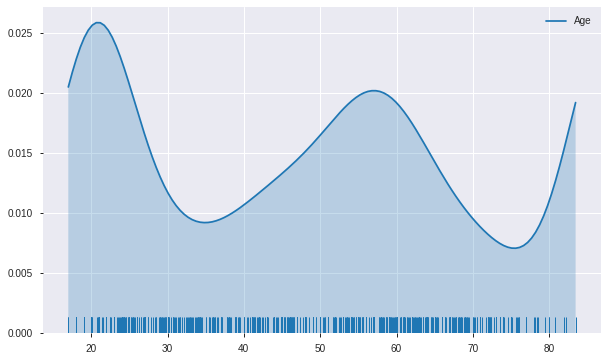

In [1058]:
fig = plt.figure(figsize=(10, 6))
sns.kdeplot(y, shade=True, cut=0)
sns.rugplot(y)
plt.show()

### eTIV by Sex

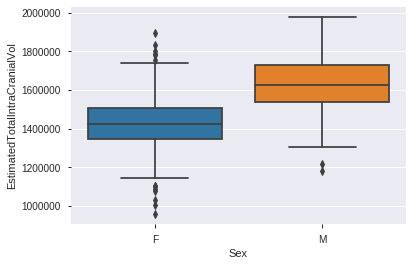

In [1059]:
fig = sns.boxplot(x='Sex', y='EstimatedTotalIntraCranialVol', data=train_data)

# Starting the fastai approach

In [1060]:
%reload_ext autoreload
%autoreload 2

In [1061]:
import sys
print(sys.path)

['/media/data/Dropbox/Arvid/MMIV.no/MMIV_conference_20191209_11/Hackathon/GitHub/mmiv-kaggle-brainage/nbs', '/home/arvid/anaconda3/envs/fastai/lib/python37.zip', '/home/arvid/anaconda3/envs/fastai/lib/python3.7', '/home/arvid/anaconda3/envs/fastai/lib/python3.7/lib-dynload', '', '/home/arvid/anaconda3/envs/fastai/lib/python3.7/site-packages', '/home/arvid/anaconda3/envs/fastai/lib/python3.7/site-packages/IPython/extensions', '/home/arvid/.ipython']


In [1062]:
import sys, fastai
print(sys.modules['fastai'])

<module 'fastai' from '/home/arvid/anaconda3/envs/fastai/lib/python3.7/site-packages/fastai/__init__.py'>


In [1063]:
from fastai.utils import *
show_install()



```text
=== Software === 
python        : 3.7.4
fastai        : 1.0.59
fastprogress  : 0.1.22
torch         : 1.3.1
nvidia driver : 418.87
torch cuda    : 10.1.243 / is available
torch cudnn   : 7603 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 5904MB | Quadro RTX 3000

=== Environment === 
platform      : Linux-4.15.0-1065-oem-x86_64-with-debian-buster-sid
distro        : #75-Ubuntu SMP Wed Nov 20 10:51:26 UTC 2019
conda env     : base
python        : /home/arvid/anaconda3/envs/fastai/bin/python
sys.path      : /media/data/Dropbox/Arvid/MMIV.no/MMIV_conference_20191209_11/Hackathon/GitHub/mmiv-kaggle-brainage/nbs
/home/arvid/anaconda3/envs/fastai/lib/python37.zip
/home/arvid/anaconda3/envs/fastai/lib/python3.7
/home/arvid/anaconda3/envs/fastai/lib/python3.7/lib-dynload

/home/arvid/anaconda3/envs/fastai/lib/python3.7/site-packages
/home/arvid/anaconda3/envs/fastai/lib/python3.7/site-packages/IPython/extensions
/home/arvid/.ipython
```

Please m

### GPU [monitoring](https://docs.fast.ai/dev/gpu.html#gpu-memory-notes)

In [1064]:
import torch
print(torch.cuda.is_available())

True


In [1065]:
if torch.cuda.is_available():
    # !nvidia-smi -h
    # !nvidia-smi --help-query-gpu
    !nvidia-smi

Wed Dec 11 15:57:03 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.00    Driver Version: 418.87.00    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Quadro RTX 3000     On   | 00000000:01:00.0 Off |                  N/A |
| N/A   52C    P8    10W /  N/A |   1673MiB /  5904MiB |     23%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Data organization

### The list of categorical features in the dataset

In [1066]:
cat_names = ['Sex']

### The list of continuous features in the dataset

In [1067]:
cont_names_1 = [
    'Left-Lateral-Ventricle', 'Right-Lateral-Ventricle',
    'lhCortexVol', 'rhCortexVol',
    'lhCerebralWhiteMatterVol', 'rhCerebralWhiteMatterVol'
]

In [1068]:
cont_names_2 = [
    'Left-Lateral-Ventricle', 'Right-Lateral-Ventricle',
    'lhCortexVol', 'rhCortexVol',
    'lhCerebralWhiteMatterVol', 'rhCerebralWhiteMatterVol'
]

In [1069]:
# tabular_data_sol_3
cont_names_3 = [
    'Left-Lateral-Ventricle', 'Right-Lateral-Ventricle',
    'lhCortexVol', 'rhCortexVol',
    'lhCerebralWhiteMatterVol', 'rhCerebralWhiteMatterVol',
    'Left-Hippocampus', 'Right-Hippocampus',
    'EstimatedTotalIntraCranialVol',
]

###  Use all the LH and RH features + non-lateralized (CC)

In [1070]:
# tabular_data_sol_4
cont_names_4 = all_lh_features + all_rh_features

In [1071]:
cont_names = cont_names_3

In [1072]:
dff = train_data[cont_names]


In [1073]:
# We may have some categorical features, let's check them
dff.select_dtypes(include=['O']).columns.tolist()

[]

In [1074]:
cont_names = set(cont_names) - set(dff.select_dtypes(include=['O']).columns.tolist())

In [1075]:
df = train_data[cont_names]

In [1076]:
# dropcolumns = [
# 'lh.aparc.thickness', 'rh.aparc.thickness'
# ]

# df = df.drop(dropcolumns, axis=1)

In [1077]:
df.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
lhCerebralWhiteMatterVol,1085.0,230812.96,29377.08,161385.47,209584.61,227604.43,249808.92,335953.89
lhCortexVol,1085.0,236371.96,32644.41,123178.57,212488.96,234823.86,259117.25,337041.40
Left-Hippocampus,1085.0,4030.63,437.06,2249.70,3752.00,4010.40,4310.50,5557.50
rhCerebralWhiteMatterVol,1085.0,230564.48,29426.91,161833.79,209171.69,227325.49,249288.98,335552.78
Right-Lateral-Ventricle,1085.0,7851.85,5212.00,2222.60,4639.00,6403.60,9455.40,56343.40
Right-Hippocampus,1085.0,4170.86,464.06,1910.30,3859.40,4152.10,4486.00,5633.30
EstimatedTotalIntraCranialVol,1085.0,1515452.15,165943.65,955810.85,1395718.42,1504274.03,1626013.35,1978181.47
Left-Lateral-Ventricle,1085.0,8635.93,5515.63,2284.70,5113.90,7219.10,10394.90,56121.40
rhCortexVol,1085.0,236925.63,32793.80,127296.07,212720.97,235287.31,259825.71,335512.31


## Pandas profiling

In [1078]:
df.profile_report(style={'full_width':True})

### To retrieve the list of variables which are rejected due to high correlation:

In [1079]:
profile = df.profile_report()
rejected_variables = profile.get_rejected_variables(threshold=0.9)
rejected_variables

['rhCerebralWhiteMatterVol', 'rhCortexVol', 'Right-Lateral-Ventricle']

## Reject highly correlated variables

In [1080]:
df.columns

Index(['lhCerebralWhiteMatterVol', 'lhCortexVol', 'Left-Hippocampus',
       'rhCerebralWhiteMatterVol', 'Right-Lateral-Ventricle',
       'Right-Hippocampus', 'EstimatedTotalIntraCranialVol',
       'Left-Lateral-Ventricle', 'rhCortexVol'],
      dtype='object')

In [1081]:
cont_names

{'EstimatedTotalIntraCranialVol',
 'Left-Hippocampus',
 'Left-Lateral-Ventricle',
 'Right-Hippocampus',
 'Right-Lateral-Ventricle',
 'lhCerebralWhiteMatterVol',
 'lhCortexVol',
 'rhCerebralWhiteMatterVol',
 'rhCortexVol'}

In [1082]:
cont_names = [item for item in df.columns if item not in rejected_variables]
cont_names

['lhCerebralWhiteMatterVol',
 'lhCortexVol',
 'Left-Hippocampus',
 'Right-Hippocampus',
 'EstimatedTotalIntraCranialVol',
 'Left-Lateral-Ventricle']

### List of processes/transforms to be applied to the dataset

In [1083]:
procs = [FillMissing, Categorify, Normalize]

### Start index for creating a validation set from train_data
Setting the index for the Validation set. The start index and End index are set in such a way that it takes the last 20% data from the training set for validation.

In [1084]:
start_indx = len(train_data) - int(len(train_data) * 0.2)

### End index for creating a validation set from train_data

In [1085]:
end_indx = len(train_data)

### TabularList for Validation

In [1086]:
val = (TabularList.from_df(train_data.iloc[start_indx:end_indx].copy(), path=path, cat_names=cat_names, cont_names=cont_names))

In [1087]:
test = (TabularList.from_df(test_data, path=path, cat_names=cat_names, cont_names=cont_names, procs=procs))

### TabularList for training

In [1088]:
data = (TabularList.from_df(train_data, path=path, cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_idx(list(range(start_indx,end_indx)))
                           .label_from_df(cols=dep_var)
                           .add_test(test)
                           .databunch())

### Display the data batch

In [1089]:
data.show_batch(rows = 10)

Sex,lhCerebralWhiteMatterVol,lhCortexVol,Left-Hippocampus,Right-Hippocampus,EstimatedTotalIntraCranialVol,Left-Lateral-Ventricle,target
F,-1.0826,-0.4725,-0.7149,-1.0388,-1.1572,-0.3601,57.0
M,0.2179,1.4227,-0.1640,0.6821,1.1845,0.1206,23.0
M,-0.2442,-0.4589,-0.8336,-1.1628,0.2699,1.4802,66.0
F,0.2880,1.2600,0.7921,0.4806,0.4463,-0.6921,21.0
F,-1.1900,-1.2145,-0.4106,-0.4351,-1.2343,-0.6857,57.0
F,-0.6127,-0.6649,-1.1583,-1.2399,-0.6530,-0.9333,54.0
M,0.4953,-0.5126,-0.0945,-0.6418,0.4473,0.8143,59.471596
M,1.6065,0.2274,1.8708,1.7477,1.5472,0.1342,33.349762
F,-0.1180,-0.7267,-0.7413,-0.4072,0.1570,0.6612,61.152634
F,-0.4976,-0.0807,-0.1295,-0.0942,-0.5076,-0.5435,23.0


## Initialising Neural Network
We will initialize a neural network with 4 layers and the number of nodes in each layer as 300,200, 100 and 50 respectively. 

The network will use two primary metrics for evaluation:

 - Root Mean Squared Error(RMSE)
 - R-Squared

In [1090]:
learn = tabular_learner(data, layers=[300,200, 100, 50], metrics= [rmse,r2_score])

### Show the complete summary of the model

In [1091]:
learn.summary

<bound method model_summary of Learner(data=TabularDataBunch;

Train: LabelList (868 items)
x: TabularList
Sex F; lhCerebralWhiteMatterVol -0.3962; lhCortexVol 0.3690; Left-Hippocampus 0.2786; Right-Hippocampus 2.2811; EstimatedTotalIntraCranialVol -0.6778; Left-Lateral-Ventricle -0.4912; ,Sex F; lhCerebralWhiteMatterVol 0.1290; lhCortexVol 0.8157; Left-Hippocampus -0.1254; Right-Hippocampus -0.0382; EstimatedTotalIntraCranialVol 0.4308; Left-Lateral-Ventricle 0.6353; ,Sex F; lhCerebralWhiteMatterVol -0.7122; lhCortexVol -1.0062; Left-Hippocampus -1.2672; Right-Hippocampus -0.8521; EstimatedTotalIntraCranialVol -1.1022; Left-Lateral-Ventricle -0.7070; ,Sex M; lhCerebralWhiteMatterVol 0.5464; lhCortexVol -0.3746; Left-Hippocampus 0.0426; Right-Hippocampus 0.9490; EstimatedTotalIntraCranialVol 0.4398; Left-Lateral-Ventricle 0.3691; ,Sex M; lhCerebralWhiteMatterVol 0.7260; lhCortexVol -0.5295; Left-Hippocampus 0.1857; Right-Hippocampus -0.4726; EstimatedTotalIntraCranialVol 0.6166; Left-L

## Training the model

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


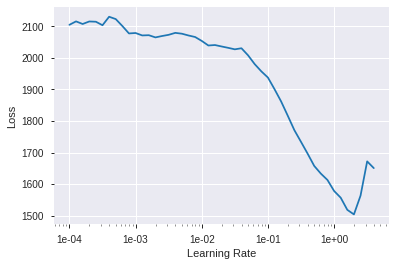

In [1092]:
# Exploring the learning rates
learn.lr_find(start_lr = 1e-05,end_lr = 1e+05, num_it = 100)
learn.recorder.plot()

Learning rate is a hyper-parameter that controls how much the weights of the network is being adjusted with respect to the loss gradient. The lr_find method helps explore the learning rate in a specified range. The graph shows the deviation in loss with respect to the learning rate.

### Fitting data and training the network

In [1093]:
# Train the network for 25 epochs
learn.fit_one_cycle(40)

epoch,train_loss,valid_loss,root_mean_squared_error,r2_score,time
0,2095.149414,2141.612793,46.226139,-4.941759,00:01
1,2068.472168,2116.734375,45.964142,-4.874798,00:01
2,2054.123047,2064.666504,45.408173,-4.734444,00:01
3,2032.060181,2005.843872,44.763428,-4.573590,00:01
4,2013.027832,1951.590698,44.159653,-4.426511,00:01
5,1991.353027,1887.417725,43.424549,-4.246459,00:01
6,1963.155640,1826.482178,42.722431,-4.079179,00:01
7,1929.375488,1787.680420,42.270363,-3.974643,00:01
8,1883.972046,1760.617188,41.953808,-3.902721,00:01
9,1831.834717,1564.924683,39.557739,-3.363397,00:01


### Evaluating the model
The `show_results` method will display the data bunches along with predicted values. 

In [1094]:
# Display predictions on the training data
learn.show_results(ds_type=DatasetType.Train,rows = 5)

Sex,lhCerebralWhiteMatterVol,lhCortexVol,Left-Hippocampus,Right-Hippocampus,EstimatedTotalIntraCranialVol,Left-Lateral-Ventricle,target,prediction
M,0.2544,-0.6408,-1.8917,-2.9209,0.2581,1.4723,80.80219,[75.10918]
F,-0.5346,-0.7353,-0.9924,-1.3799,-1.0234,-0.9437,31.956194,[40.73905]
F,-0.6538,-1.2316,-1.1621,-1.1964,-0.8321,-0.0915,46.590008,[49.949104]
F,0.3958,0.2015,0.3646,0.1905,0.1741,-0.5495,26.52156,[22.517477]
M,0.3405,-0.0007,0.6504,0.4280,0.7856,-0.6060,50.0,[40.055542]


In [1095]:
# Display predictions on the validation data
learn.show_results(ds_type=DatasetType.Valid)

Sex,lhCerebralWhiteMatterVol,lhCortexVol,Left-Hippocampus,Right-Hippocampus,EstimatedTotalIntraCranialVol,Left-Lateral-Ventricle,target,prediction
F,-0.0418,-0.3300,-1.3397,-1.1693,-0.5980,-0.0442,60.0,[55.788235]
M,-0.7080,0.7855,1.2837,1.2214,0.4692,-0.5186,21.0,[20.427477]
M,0.0475,1.9247,0.9952,1.0098,1.2222,-0.1648,23.0,[17.02045]
M,0.2009,-0.2885,0.7030,0.4732,0.3308,-0.2763,56.67625,[50.228657]
F,-1.0103,-1.2407,-1.3428,-1.2806,-1.4306,-0.8002,39.397675,[42.938194]


### Fetching the Metrics 

In [1096]:
# Getting the training and validation errors
tr = learn.validate(learn.data.train_dl)
va = learn.validate(learn.data.valid_dl)
print("The metrics used in evaluating the network:", str(learn.metrics))
print("\nThe calculated RMSE & R-Squared for the training set :", tr[1:])
print("\nThe calculated RMSE & R-Squared for the validation set :", va[1:])

The metrics used in evaluating the network: [<function root_mean_squared_error at 0x7f2e77318290>, <function r2_score at 0x7f2e77318440>]

The calculated RMSE & R-Squared for the training set : [tensor(7.6409), tensor(0.8230)]

The calculated RMSE & R-Squared for the validation set : [tensor(10.6999), tensor(0.6756)]


#### SUMMARY

The Root Mean Squared Error is the standard deviation of the errors/residuals. It tells us the ‘Goodness Of Fit’ of a model. The lower the value of RMSE the better the model.

The R-Squared metric also called the coefficient of determination is used to understand the variation in the dependent variable(y) and the independent variable(X).The closer the value of R-Squared is to one, the better the model.

The above output suggests that:

The model/network was able to attain an RMSE of 1.4678 and an R-squared of 0.9726 while training and an RMSE of 3.1737 and an R-squared of 0.9107 while Validating on the validation set.

### Plotting the losses for training and validation

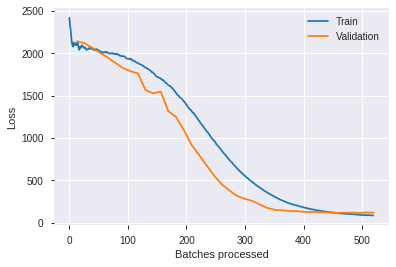

In [1097]:
learn.recorder.plot_losses()

The above graph shows the change in loss during the course of training the network. At the beginning of the training, we can see a high loss value. As the networks learned from the data, the loss started to drop until it could no longer improve during the course of training. The validation shows a relatively consistent and low loss values. 

Note: The validation losses are only calculated once per epoch, whereas training losses are calculated after each batch

### Plotting the learning rate, momentum and metrics

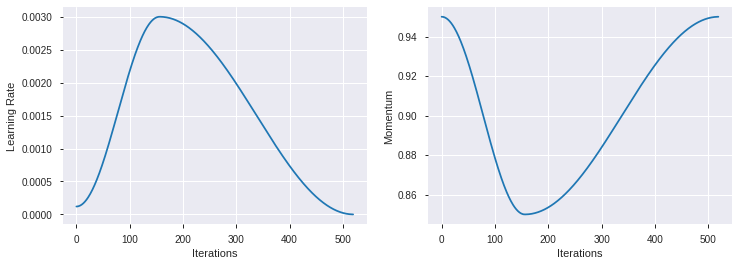

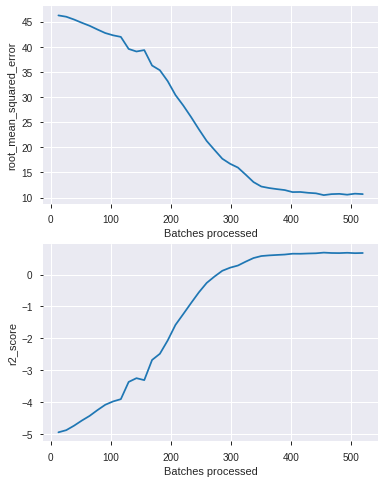

In [1098]:
# Plotting momentum & learning rate
learn.recorder.plot_lr(show_moms=True)
# Plotting the metrics of evaluation
learn.recorder.plot_metrics()

### A simple analysis on the predictions of validation set

Plotting the average Age for a given Sex, -- actual vs predicted

No handles with labels found to put in legend.


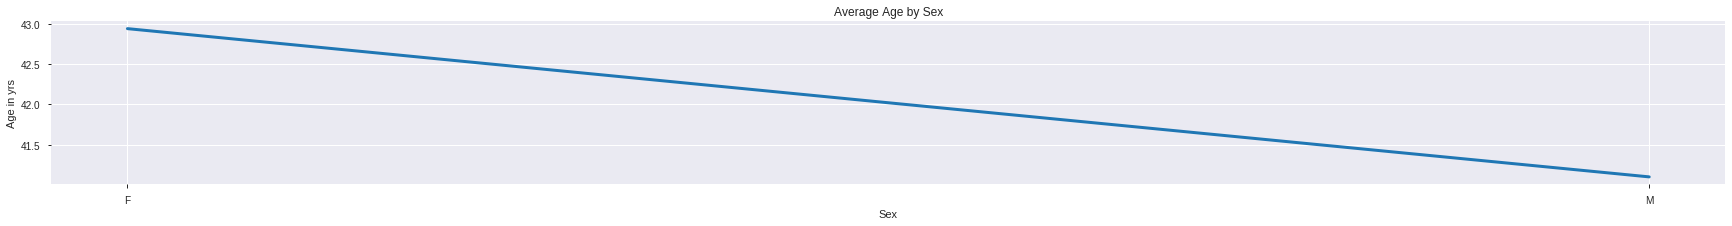

In [1099]:
plt.figure(figsize=(30, 3))
# plt.plot(val.groupby(['Sex']).mean()['Age'], linewidth = 3, )
plt.plot(train_data.groupby(['Sex']).mean()['Age'], linewidth = 3, )
#plt.plot(val.groupby(['Sex']).mean()['Predicted'],linewidth = 5, ls  = '--')
plt.title('Average Age by Sex')
plt.xlabel('Sex')
plt.ylabel('Age in yrs')
plt.legend()
plt.show()

## Predicting Using The Network

In [1100]:
# Predicting for a single observation
# Test set data for row 0
test_data.iloc[0]

SubjectID                                  117
Sex                                          F
Measure:volume                               0
Left-Lateral-Ventricle                  9018.3
Left-Inf-Lat-Vent                          293
                                      ...     
rh_transversetemporal_thickness          2.259
rh_insula_thickness                      2.923
rh_MeanThickness_thickness             2.43364
BrainSegVolNotVent                 1.07088e+06
eTIV_y                             1.44902e+06
Name: 0, Length: 143, dtype: object

In [1101]:
# Predicting for the complete test set
test_predictions = learn.get_preds(ds_type=DatasetType.Test)[0]

# Converting the tensor output to a list of predicted values
test_predictions = [i[0] for i in test_predictions.tolist()]

# Converting the prediction to a dataframe
test_predictions = pd.DataFrame(test_predictions, columns = ['Age'])

test_predictions.head(2)

,Age
0,53.457386
1,48.693710


In [1102]:
test_predictions.tail(2)

,Age
464,40.00108
465,17.44643


In [1103]:
sampleSubmission = pd.read_csv('../data/sampleSubmission.csv')
sampleSubmission.label =  test_predictions.Age.round(0).astype(int)
my_test_predictions = sampleSubmission.copy()

In [1104]:
# Writing the predictions to an csv file.
my_test_predictions.to_csv("tabular_data_sol_3.csv", index = False)

In [1105]:
!ls .

brain_age_classification.ipynb	   models
brain_age_explore_in_r.ipynb	   numpy-basics.ipynb
brain_age_explore.ipynb		   pandas-basics.ipynb
brain_age_regression_fastai.ipynb  python-basics.ipynb
brain_age_regression.ipynb	   scikit-learn-basics.ipynb
fastai_solution_1.csv		   submission.csv
fastai_solution_3.csv		   tabular_data_sol_3.csv
Fast_ai_solution.csv		   tabular_data_sol_4.csv
kernel_density_estimation.ipynb


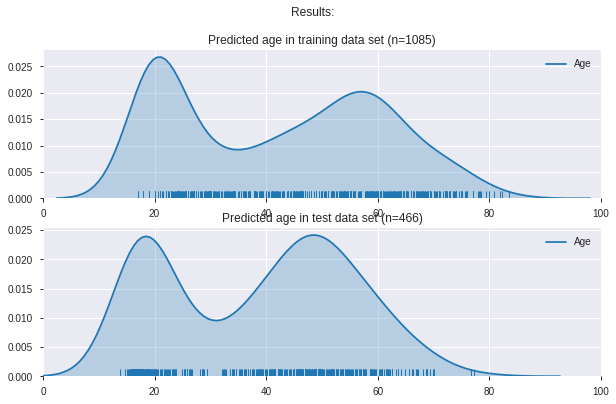

In [1106]:
fig = plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
sns.kdeplot(y, shade=True)
sns.rugplot(y)
plt.xlim(0, 100)
plt.title("Predicted age in training data set (n=%d)" % (len(train_data)) )

plt.subplot(2, 1, 2)
y_pred = test_predictions.Age
sns.kdeplot(y_pred, shade=True)
sns.rugplot(y_pred)
plt.xlim(0, 100)
fig.suptitle('Results:') 
plt.title("\nPredicted age in test data set (n=%d)" % (len(my_test_predictions)) )

plt.show()

In [1107]:
my_test_predictions 

,IDX,label
0,117,53
1,1076,49
2,903,50
3,1128,59
4,817,42
...,...,...
461,1002,17
462,944,54
463,804,23
464,443,40


### Discretization of Age variable
Quantile-based discretization function. Discretize variable into equal-sized buckets based on rank or based on sample quantiles. For example 1000 values for 10 quantiles would produce a Categorical object indicating quantile membership for each data point.

In [1108]:
pd.qcut(train_data['Age'], 8).head(1)

0    (16.999, 20.0]
Name: Age, dtype: category
Categories (8, interval[float64]): [(16.999, 20.0] < (20.0, 21.0] < (21.0, 30.06] < (30.06, 44.0] < (44.0, 52.515] < (52.515, 58.0] < (58.0, 64.0] < (64.0, 83.458]]